# Visualizing Neuronal Unit Spikes

Some of this content is adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html).

After processing Neuropixel ecephys data with [Kilosort](https://github.com/MouseLand/Kilosort), individual units have been identified and are stored in the `Units` section of the NWB file. Here, you can examine the spiking behavior of these units and examine individual units and their associated waveforms.

### Environment Setup

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from dandi import dandiapi
from pynwb import NWBHDF5IO

%matplotlib inline

### Downloading an NWB File
If you don't already have a file to analyze, you can use a file from The Allen Institute's `Visual Coding - Neuropixels` dataset. If you want to choose your own file to download, set `dandiset_id` and `dandi_filepath` accordingly.

In [5]:
dandiset_id = "000021"
dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"
download_loc = "."

In [6]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [ ]:
my_dandiset = dandiapi.DandiAPIClient().get_dandiset(dandiset_id)
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

### Extracting Unit Data
The `Units` section is formatted as a table. Individual units are identified with the `id` column. Note that, while each id is unique, they are not perfectly ordinal; some ids are missing. In the cells below, the unit properties are listed and a slice of the units table is shown. More information on several unit properties can be found in [Visualizing Unit Quality Metrics](visualize_unit_metrics.ipynb)

In [7]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 
units = nwb.units.to_dataframe()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [15]:
units[:]

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,local_index,spread,waveform_halfwidth,d_prime,presence_ratio,repolarization_slope,nn_hit_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950921187,0.604355,4,850249267,481.80,0.425574,2.209140,-0.118430,17.537571,0.009496,0.036369,...,4,50.0,0.357119,2.962274,0.99,0.381716,0.473829,"[1.0439430431793884, 1.543311060144649, 2.7287...","[0.0001908626967721937, 0.00016134635752077775...","[[0.0, 0.5961149999999966, 5.378099999999993, ..."
950921172,0.521943,3,850249267,681.53,0.390098,1.959983,-0.109729,14.677643,0.003857,0.103446,...,3,40.0,0.260972,2.067810,0.99,0.536663,0.445946,"[10.406435026164546, 17.127986534673788, 18.48...","[0.00014485615850768024, 0.0001722424107984555...","[[0.0, -1.341600000000002, -0.4586399999999933..."
950921152,0.467002,2,850249267,1070.71,0.500000,2.522905,-0.109867,15.783665,0.017776,0.027818,...,2,50.0,0.247236,2.220043,0.99,0.566559,0.284058,"[1.2775103414155262, 2.3915133536963493, 3.701...","[0.00014859435856024575, 0.0001531048673600236...","[[0.0, -0.6427199999999993, -2.836079999999998..."
950921135,0.467002,1,850249267,253.42,0.500000,2.803475,-0.150379,26.666930,0.023742,0.076530,...,1,40.0,0.233501,2.339206,0.99,0.669090,0.590737,"[9.473732504122962, 13.198542576065163, 18.302...","[0.00032386170367170055, 0.0004518112387675137...","[[0.0, -3.2800950000000078, -6.087510000000009..."
950921111,0.439531,0,850249267,141.82,0.018056,4.647943,-0.328727,66.901065,0.006595,NaN,...,0,30.0,0.219765,4.395994,0.99,1.261416,0.952667,"[1.1677100445138795, 1.1707767194728813, 1.349...","[0.00015644521007973124, 0.000214412247939483,...","[[0.0, -0.9291749999999945, -6.120270000000007..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950958827,0.686767,327,850256505,425.47,0.013262,1.197137,-0.033924,47.100934,0.000569,0.003954,...,323,70.0,0.219765,3.495039,0.99,0.166195,0.562500,"[56.68879155534432, 56.71539151930708, 140.382...","[7.006826592238747e-05, 6.896932990521833e-05,...","[[0.0, 1.456064999999999, -2.1444149999999933,..."
950958817,0.535678,326,850256505,391.97,0.029259,2.162418,-0.045889,44.871938,0.004134,-0.030602,...,322,50.0,0.164824,3.535095,0.96,0.374690,0.618474,"[32.77642395146384, 53.25072954651286, 53.3577...","[7.075155819535531e-05, 7.864810630992507e-05,...","[[0.0, 5.052254999999994, -0.3732300000000003,..."
950958015,0.576884,236,850256505,195.00,0.003844,3.398071,-0.072890,43.340940,0.001142,-0.127013,...,232,40.0,0.137353,4.977663,0.92,0.634695,0.767932,"[171.13333650757914, 614.5358357924764, 895.59...","[9.143536229559716e-05, 0.00010639289111014194...","[[0.0, 7.7005500000000175, 12.612210000000019,..."


### Filtering Units
It might be of interest to only examine units with certain properties. They can be selected based on any metric. Below, only units with a 'good' quality SNR are chosen, along with a few other choices.

In [16]:
# selected_units = units[units.quality == 'good']
selected_units = units[units.firing_rate > 5]
# selected_units = units[units.cumulative_drift < 200]
selected_units.shape

(974, 29)

### Showing Spike Times
Here, a histogram plot of unit spikes over time is created. Set `stim_time` to be the time of the stimulus you're interested in viewing. `interval_start` and `interval_end` to the relative time bounds of the histogram around `stim_time`. Finally, `start_unit` and `end_unit` can be used to choose the slice indices of `selected_units` to display. 

In [62]:
stim_time = 800 # arbitrarily chosen here
interval_start = -0.1
interval_end = 5

start_unit = 0
end_unit = 200

In [63]:
spike_times = [elem for elem in selected_units.spike_times[start_unit:end_unit]]
if len(spike_times) == 0:
    raise Exception("There are no spiking units in this selection")
len(spike_times)

200

In [64]:
# generate histograms with 200 bins for each unit
time_bin_edges = np.linspace(interval_start, interval_end, 200)
hists = []
for unit_spike_times in spike_times:
    hist, bins = np.histogram(unit_spike_times-stim_time, bins=time_bin_edges)
    hists.append(hist)
hists = np.array(hists)

hists.shape

(200, 199)

Text(0.5, 1.0, 'unit spikes over time')

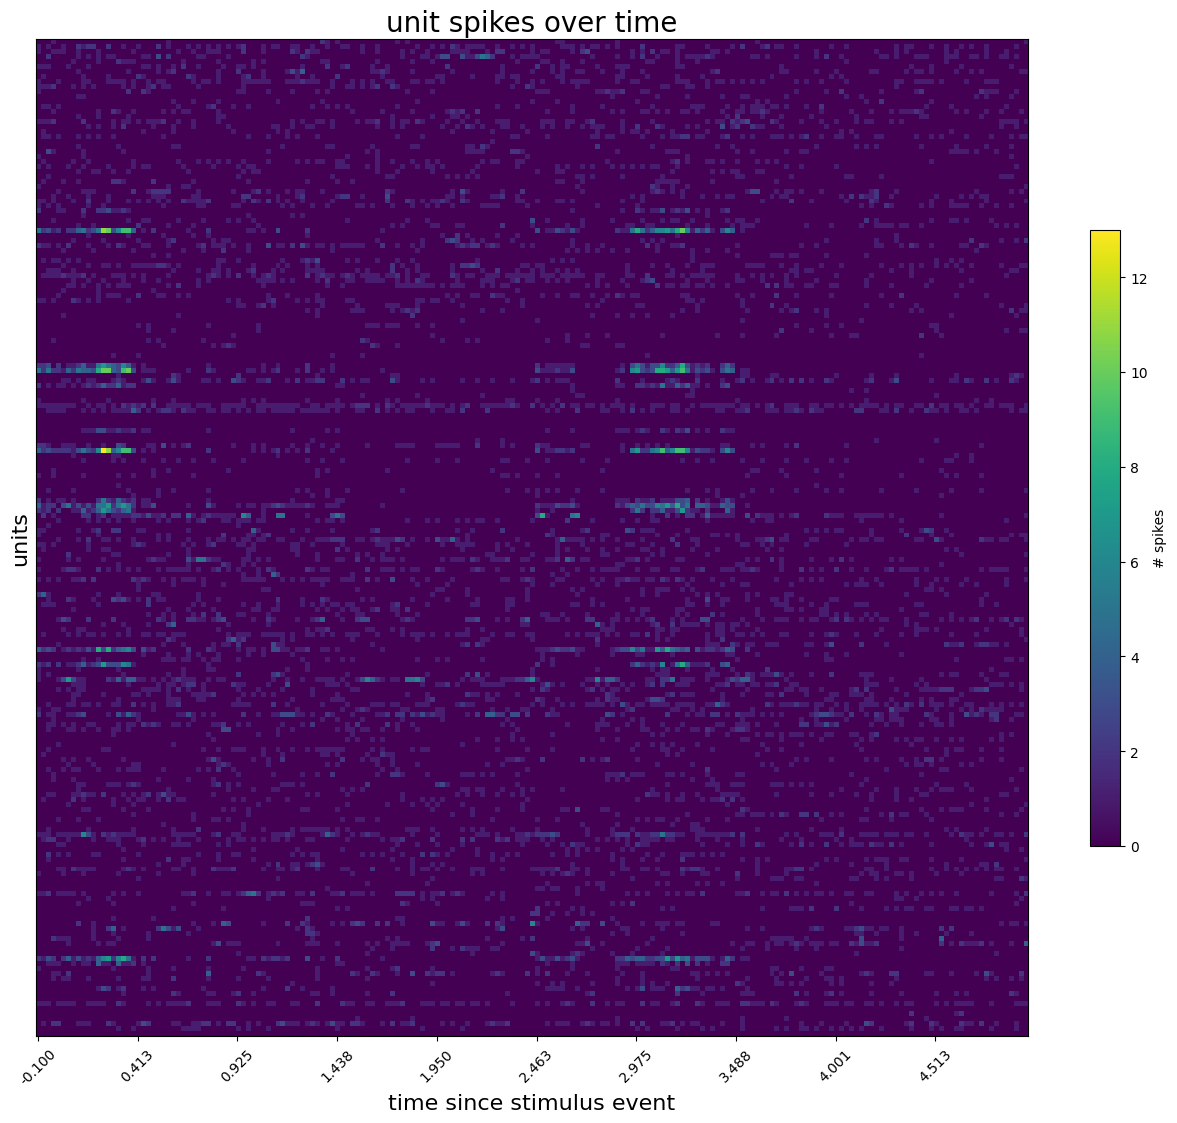

In [65]:
fig, ax = plt.subplots(figsize=(16,16))
img = ax.imshow(hists)
cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label('# spikes')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("units", fontsize=16)

xtick_step=20
reltime = np.array(time_bin_edges)
ax.set_xticks(np.arange(0, len(reltime), xtick_step))
ax.set_xticklabels([f'{mp:1.3f}' for mp in reltime[::xtick_step]], rotation=45)

ax.set_xlabel("time since stimulus event", fontsize=16)
ax.set_title("unit spikes over time", fontsize=20)

### Unit Responses throughout Epochs

### Waveforms

In [27]:
unit_num = 950921135

#### Time-wise waveforms

In [68]:
len(units.waveform_mean[unit_num])

384

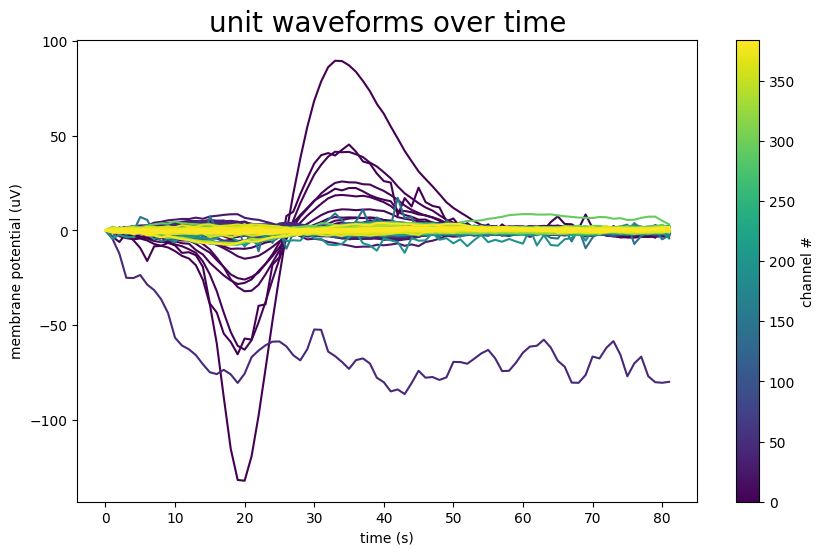

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(units.waveform_mean[unit_num])))
ax.set_prop_cycle(color=colors)
ax.plot(np.transpose(units.waveform_mean[unit_num]))

norm = mpl.colors.Normalize(vmin=0, vmax=len(colors))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, label='channel #')

ax.set_xlabel("time (s)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("unit waveforms over time", fontsize=20)

plt.show()

#### Channel-wise waveforms

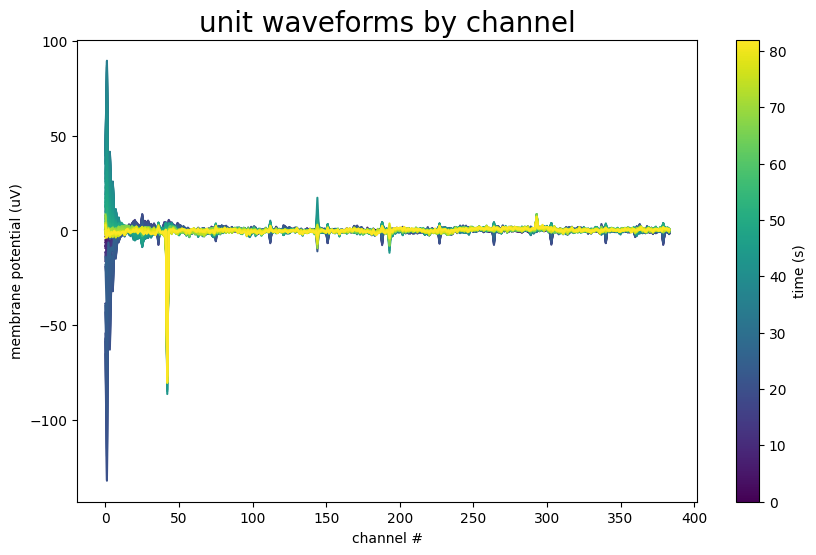

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.transpose(units.waveform_mean[unit_num])) ))
ax.set_prop_cycle(color=colors)
ax.plot(units.waveform_mean[unit_num])

norm = mpl.colors.Normalize(vmin=0, vmax=len(colors))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, label='time (s)')

ax.set_xlabel("channel #")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("unit waveforms by channel", fontsize=20)

plt.show()

#### Average waveform across channels

In [31]:
avg_waveform = np.average(units.waveform_mean[unit_num],axis=0)
avg_waveform.shape

(82,)

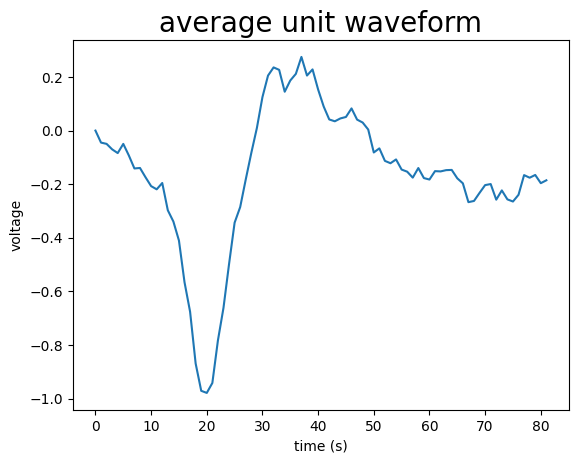

In [35]:
fig, ax = plt.subplots()
ax.plot(avg_waveform)

ax.set_xlabel("time (s)")
ax.set_ylabel("voltage")
ax.set_title("average unit waveform", fontsize=20)

plt.show()